# Makemore part 3

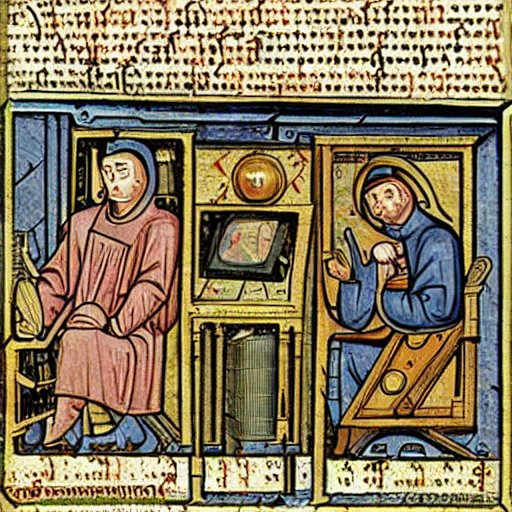

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(set("".join(words)))
stoi = {chars[i]:i+1 for i in range(len(chars))}
stoi['.'] = 0
itos = {i:c for c,i in stoi.items()}
vocab_size = len(itos)
vocab_size

27

In [18]:
block_size = 3 # context length

def build_dataset(words):
    X, Y = [], []
    i = 0
    for w in words:
        context = [0] * block_size
        for c in w + '.':
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            i += 1
            #if i < 32:
            # print (f'{i:02d}  ',"".join([itos[x] for x in context]), '--->', itos[ix])
            context = context[1:] + [ix] # crop 1 and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

len(Xtr), len(Xdev), len(Xte)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


(182625, 22655, 22866)

In [155]:
# MLP revisited (mult layer perceptron)
n_embd = 10 # dimensionality of character embedding
n_hidden = 200 # neuron count in hidden layer

g  = torch.Generator().manual_seed(2147483647) 
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size )** 0.5)
# b1 = torch.randn((n_hidden),                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn((vocab_size),                    generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.ones((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print('MLP param count:', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    

MLP param count: 12097


tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, T

In [147]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps ):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y (labels)
    
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 # hidden pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    # batch normalization, scale and shift 
    hpreact = bnbias + bngain * (hpreact - bnmeani) / bnstdi
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3056
  10000/ 200000: 1.9817
  20000/ 200000: 2.6418
  30000/ 200000: 2.0012
  40000/ 200000: 2.3115
  50000/ 200000: 1.8987
  60000/ 200000: 2.0529
  70000/ 200000: 2.3327
  80000/ 200000: 2.4092
  90000/ 200000: 2.2383
 100000/ 200000: 2.2589
 110000/ 200000: 2.2823
 120000/ 200000: 1.6926
 130000/ 200000: 1.9830
 140000/ 200000: 2.2002
 150000/ 200000: 2.0063
 160000/ 200000: 1.9524
 170000/ 200000: 2.4093
 180000/ 200000: 2.1574
 190000/ 200000: 2.2078


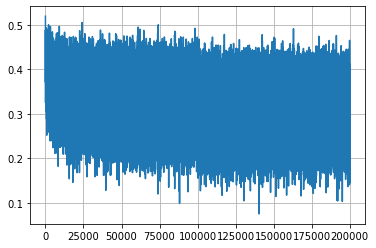

In [111]:
plt.plot(lossi[:])
plt.grid("minor")

(array([794., 145., 115.,  84.,  73.,  64.,  54.,  62.,  55.,  43.,  49.,
         45.,  41.,  52.,  40.,  53.,  33.,  66.,  78.,  65.,  68.,  90.,
        156., 282., 573., 510., 309., 146.,  91.,  76.,  72.,  32.,  46.,
         64.,  40.,  33.,  46.,  44.,  46.,  71.,  41.,  74.,  56.,  51.,
         74.,  65., 113., 134., 167., 819.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

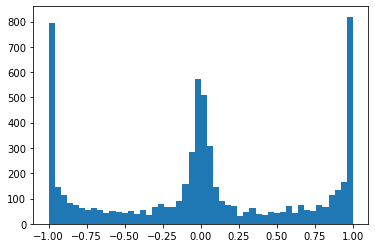

In [112]:
plt.hist(h.view(-1).tolist(), 50)

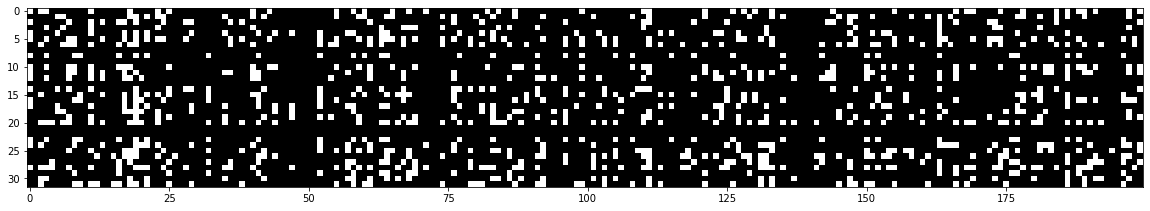

In [113]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [148]:
@torch.no_grad() # this decorator disables gadient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(f'{split}: {loss.item():.5f}')
    
split_loss("train")
split_loss("val")

train: 2.06642
val: 2.11134


In [151]:
# sample from the model:
def sample():
    out = []
    context = [0] * block_size 
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1) 
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # add new letter we picked, discard oldest one
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    return ''.join(itos[i] for i in out)

for i in range(20):
    print(f'{i:02d} {sample()}')

00 traxtonni.
01 arrie.
02 dara.
03 janyonnika.
04 evrita.
05 thten.
06 chillee.
07 mack.
08 deyen.
09 yina.
10 latta.
11 nesiah.
12 gwayesen.
13 eler.
14 adrianniq.
15 pron.
16 tin.
17 drah.
18 wille.
19 izan.
